## Hotels rate analysis

### Base env setup and loading data

In [207]:
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from dotenv import load_dotenv
import re
import time

load_dotenv(override=True)

client = MongoClient(os.getenv('MONGODB_URI'))
db = client[os.getenv('MONGODB_DB_NAME')]

websites = ['expedia', 'hotels']
dataframes = {}

for website in websites:
    collection = db[website]
    cursor = collection.find({})
    dataframes[website] = pd.DataFrame(list(cursor))

In [208]:
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from scipy.spatial import cKDTree
import numpy as np
import time
import re
import traceback
import random
import pycountry
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
from requests.exceptions import RequestException


class GeoCache:
    def __init__(self):
        self.coords = []
        self.cities = []
        self.kdtree = None

    def add(self, lat, lon, city):
        self.coords.append((lat, lon))
        self.cities.append(city)
        self.kdtree = cKDTree(self.coords)

    def get_nearest(self, lat, lon, max_distance=5):
        try:
            if not self.kdtree or len(self.coords) == 0:
                return None
            
            query_point = np.array([[lat, lon]])
            distances, indices = self.kdtree.query(query_point, k=1)
            
            # Extract the scalar values from the numpy arrays
            distance = distances.item()
            index = indices.item()
            
            if distance <= max_distance:
                return self.cities[index]
            return None
        except Exception as e:
            print(f"Error in get_nearest: {str(e)}")
            print(f"Problematic coordinates: lat={lat}, lon={lon}")
            print("Traceback:")
            print(traceback.format_exc())
            return None

geo_cache = GeoCache()


def get_city_from_place(place_name, max_retries=3, initial_delay=1, backoff_factor=2):
    if not isinstance(place_name, str):
        return None

    # Clean the place name
    place_name = clean_city_name(place_name)

   
    geolocator = Nominatim(user_agent="my_app", timeout=10)
    
            # First, try to geocode the place name
    location = geolocator.geocode(place_name, language='en')
    if location:
        # Use get_city_from_coordinates to get the city name
        return get_city_from_coordinates(location.latitude, location.longitude)

    # If geocoding fails, try to extract a city name from the original place_name
    words = place_name.split()
    if len(words) > 1:
        # Assume the first word that's not a common prefix might be a city name
        common_prefixes = ['downtown', 'central', 'greater', 'old', 'new', 'north', 'south', 'east', 'west']
        for word in words:
            if word.lower() not in common_prefixes:
                return word

    # If all else fails, return the original cleaned place name
    return place_name

def clean_city_name(name):
    # Remove common prefixes
    prefixes_to_remove = ['City of', 'Town of', 'Village of', 'Municipality of', 'District of']
    for prefix in prefixes_to_remove:
        if name.lower().startswith(prefix.lower()):
            name = name[len(prefix):].strip()
    
    # Remove any parenthetical content
    name = re.sub(r'\([^)]*\)', '', name).strip()
    
    # Remove any numbers or extra whitespace
    name = re.sub(r'\d+', '', name).strip()
    name = ' '.join(name.split())
    
    return name


def get_city_from_coordinates(latitude, longitude, max_retries=3, initial_delay=1, backoff_factor=2):
    try:
        # Check cache first
        cached_city = geo_cache.get_nearest(latitude, longitude)
        if cached_city:
            return cached_city

        geolocator = Nominatim(user_agent="my_app", timeout=10)
        
        for attempt in range(max_retries):
            try:
                location = geolocator.reverse(f"{latitude}, {longitude}", language='en')
                address = location.raw['address']
                
                # Try to get the English country name
                country_code = address.get('country_code', '').upper()
                country = pycountry.countries.get(alpha_2=country_code)
                country_name = country.name if country else address.get('country', '')

                # Prioritize English names
                city = address.get('city', '')
                if not city:
                    city = address.get('town', '')
                if not city:
                    city = address.get('village', '')
                if not city:
                    city = address.get('suburb', '')

                # If we still don't have a city name, use the state or country
                if not city:
                    city = address.get('state', '')
                if not city:
                    city = country_name

                city = clean_city_name(city)
                
                # Add country name for disambiguation if available
                if country_name and country_name.lower() not in city.lower():
                    city = f"{city}, {country_name}"
                
                # Add to cache
                geo_cache.add(latitude, longitude, city)
                
                return city
            except (GeocoderTimedOut, GeocoderServiceError, RequestException) as e:
                if attempt == max_retries - 1:
                    raise
                delay = initial_delay * (backoff_factor ** attempt) + random.uniform(0, 1)
                print(f"Geocoding attempt {attempt + 1} failed. Retrying in {delay:.2f} seconds...")
                time.sleep(delay)

    except Exception as e:
        print(f"Error in get_city_from_coordinates: {str(e)}")
        print(f"Problematic coordinates: {latitude}, {longitude}")
        print("Traceback:")
        print(traceback.format_exc())
        return None
    
def extract_total(price_data):
    try:
        if isinstance(price_data, str):
            # If price_data is a string, extract the number directly
            match = re.search(r'\$(\d+)', price_data)
            return int(match.group(1)) if match else None
        elif isinstance(price_data, dict) and 'display' in price_data:
            # Regular expression pattern to match "$X total"
            pattern = r'\$(\d+)\s+total'
            
            # Iterate through the 'display' list
            for item in price_data['display']:
                # Check if the item has a 'text' key
                if 'text' in item:
                    # Try to match the pattern in the text
                    match = re.search(pattern, item['text'])
                    if match:
                        # Return the matched number as an integer
                        return int(match.group(1))
        
        # If no match is found, return None
        return None
    except Exception as e:
        print(f"Error in extract_total: {str(e)}")
        print(f"Problematic price_data: {price_data}")
        return None



In [213]:
import traceback
import pandas as pd

def safe_apply(func):
    def wrapper(x):
        try:
            return func(x)
        except Exception as e:
            print(f"Error in apply function: {str(e)}")
            print(f"Problematic input: {x}")
            return None
    return wrapper

def preprocess_expedia_df(df):
    new_df = pd.DataFrame()
    try:
        if not isinstance(df, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")

        # Price extraction
        if 'price' in df.columns:
            new_df['price'] = df['price'].apply(safe_apply(extract_total))
            print("Extracted prices for Expedia data")
        else:
            print("Warning: 'price' column not found in Expedia data")

        # City extraction
        if 'coordinate' in df.columns:
            new_df['city'] = df.apply(safe_apply(lambda x: get_city_from_coordinates(
                x['coordinate'].get('latitude') if isinstance(x['coordinate'], dict) else None,
                x['coordinate'].get('longitude') if isinstance(x['coordinate'], dict) else None
            ) if pd.notna(x['coordinate']) else None), axis=1)
            print("Extracted cities for Expedia data")
        else:
            print("Warning: 'coordinate' column not found in Expedia data")

        # Star rating extraction
        if 'reviews' in df.columns:
            new_df['star_rating'] = df['reviews'].apply(safe_apply(lambda x: x['score']/2 if isinstance(x, dict) and 'score' in x else None))
            print("Extracted star ratings for Expedia data")
        else:
            print("Warning: 'reviews' column not found in Expedia data")

        # Hotel name extraction
        if 'name' in df.columns:
            new_df['hotel_name'] = df['name']
            print("Extracted hotel names for Expedia data")
        else:
            print("Warning: 'name' column not found in Expedia data")

    except Exception as e:
        print(f"Error in preprocess_expedia_df: {str(e)}")
        print("Traceback:")
        print(traceback.format_exc())
        if not df.empty:
            print(f"Problematic row: {df.iloc[0] if len(df) > 0 else 'No rows'}")
            print(f"DataFrame columns: {df.columns}")
            print(f"DataFrame dtypes: {df.dtypes}")
        else:
            print("DataFrame is empty")
    new_df.drop_duplicates(inplace=True)
    print(f"Number of rows after cleaning Expedia: {new_df.count()}")
    return new_df

def preprocess_hotels_df(df):
    new_df = pd.DataFrame()
    try:
        if not isinstance(df, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")

        # Price extraction
        if 'price' in df.columns:
            new_df['price'] = df['price'].apply(safe_apply(extract_total))
            print("Extracted prices for Hotels.com data")
        else:
            print("Warning: 'price' column not found in Hotels.com data")

        # City extraction
        if 'place' in df.columns:
            new_df['city'] = df['place'].apply(safe_apply(lambda x: get_city_from_place(x) if pd.notna(x) else None))
            print("Extracted cities for Hotels.com data")
        else:
            print("Warning: 'place' column not found in Hotels.com data")

        # Star rating extraction
        if 'stars' in df.columns:
            new_df['star_rating'] = df['stars'].apply(safe_apply(lambda x: float(x) if pd.notna(x) and x != '' else None))
            print("Extracted star ratings for Hotels.com data")
        else:
            print("Warning: 'stars' column not found in Hotels.com data")

        # Hotel name extraction
        if 'hotelName' in df.columns:
            new_df['hotel_name'] = df['hotelName']
            print("Extracted hotel names for Hotels.com data")
        else:
            print("Warning: 'hotelName' column not found in Hotels.com data")

    except Exception as e:
        print(f"Error in preprocess_hotels_df: {str(e)}")
        print("Traceback:")
        print(traceback.format_exc())
        if not df.empty:
            print(f"Problematic row: {df.iloc[0] if len(df) > 0 else 'No rows'}")
            print(f"DataFrame columns: {df.columns}")
            print(f"DataFrame dtypes: {df.dtypes}")
        else:
            print("DataFrame is empty")
    new_df.drop_duplicates(inplace=True)
    print(f"Number of rows after cleaning Hotels.com: {new_df.count()}")
    return new_df

In [214]:
from joblib import Parallel, delayed

def process_dataframe(website, df, preprocess_func):
    return website, preprocess_func(df)

def parallel_preprocessing(dataframes):
    # Define the number of jobs (usually the number of CPU cores)
    n_jobs = -1  # -1 means use all available cores

    # Prepare the tasks
    tasks = [
        ('expedia', dataframes['expedia'], preprocess_expedia_df),
        ('hotels', dataframes['hotels'], preprocess_hotels_df)
    ]

    # Execute the preprocessing in parallel
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_dataframe)(website, df, func)
        for website, df, func in tasks
    )

    # Combine the results into a dictionary
    clean_df = dict(results)

    return clean_df

# Use the parallel preprocessing function
clean_df = parallel_preprocessing(dataframes)


Extracted prices for Hotels.com data
Extracted prices for Expedia data
Extracted cities for Expedia data
Extracted star ratings for Expedia data
Extracted hotel names for Expedia data
Number of rows after cleaning Expedia: price          1494
city           1500
star_rating    1491
hotel_name     1500
dtype: int64
Extracted cities for Hotels.com data
Extracted star ratings for Hotels.com data
Extracted hotel names for Hotels.com data
Number of rows after cleaning Hotels.com: price          716
city           858
star_rating     48
hotel_name     858
dtype: int64


In [215]:
# fill missing values
clean_df['hotels']['star_rating'].fillna(3, inplace=True)
clean_df['expedia']['star_rating'].fillna(3, inplace=True)

/tmp/ipykernel_22351/2873880858.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  clean_df['hotels']['star_rating'].fillna(3, inplace=True)
/tmp/ipykernel_22351/2873880858.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=T

In [216]:
# write to mongodb
from pymongo import MongoClient
from bson import json_util
import json

def write_to_mongodb(clean_df, db_name, collection_name):
    try:
        # Connect to MongoDB
        client = MongoClient(os.getenv('MONGODB_URI'))
        db = client[db_name]
        collection = db[collection_name]

        # Convert DataFrame to a list of dictionaries
        records = json.loads(clean_df.to_json(orient='records'))

        # Use json_util.dumps to handle MongoDB-specific data types
        records = [json.loads(json_util.dumps(record)) for record in records]

        # Insert the records into MongoDB
        result = collection.insert_many(records)

        print(f"Successfully inserted {len(result.inserted_ids)} documents into {collection_name}")

    except Exception as e:
        print(f"Error writing to MongoDB: {str(e)}")
        print("Traceback:")
        print(traceback.format_exc())

    finally:
        client.close()

# Usage
db_name = 'clean_hotels_data'
write_to_mongodb(clean_df['expedia'], db_name, 'clean_expedia')
write_to_mongodb(clean_df['hotels'], db_name, 'clean_hotels')

Successfully inserted 1500 documents into clean_expedia
Successfully inserted 858 documents into clean_hotels


### Rate Comparison

To determine which hotel listing site offers better rates, we'll consider multiple factors:
Average price comparison:

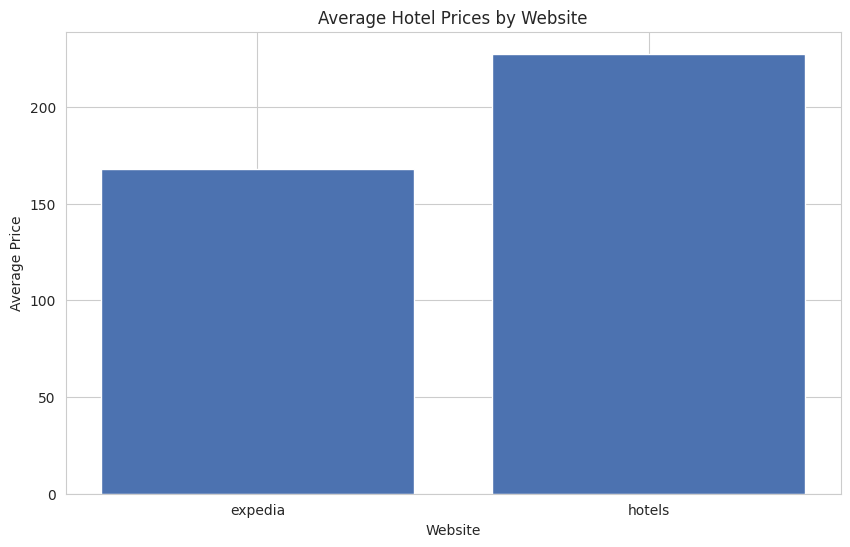

Average prices:
expedia: $167.74
hotels: $227.58


In [219]:
avg_prices = {website: df['price'].mean() for website, df in clean_df.items()}

plt.figure(figsize=(10, 6))
plt.bar(avg_prices.keys(), avg_prices.values())
plt.title('Average Hotel Prices by Website')
plt.xlabel('Website')
plt.ylabel('Average Price')
plt.show()

print("Average prices:")
for website, avg_price in avg_prices.items():
    print(f"{website}: ${avg_price:.2f}")

Price distribution comparison:

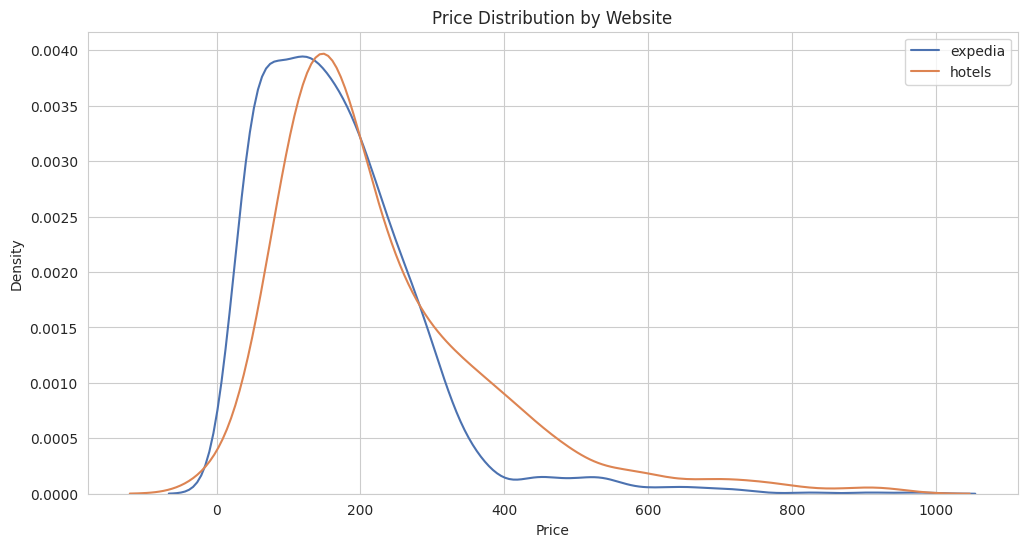

In [220]:
plt.figure(figsize=(12, 6))
for website, df in clean_df.items():
    sns.kdeplot(df['price'], label=website)

plt.title('Price Distribution by Website')
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()
plt.show()

Median and interquartile range (IQR) comparison:

In [221]:
price_stats = {}
for website, df in clean_df.items():
    q1 = df['price'].quantile(0.25)
    q3 = df['price'].quantile(0.75)
    price_stats[website] = {
        'median': df['price'].median(),
        'iqr': q3 - q1
    }

print("Price statistics:")
for website, stats in price_stats.items():
    print(f"{website}: Median = ${stats['median']:.2f}, IQR = ${stats['iqr']:.2f}")

Price statistics:
expedia: Median = $150.00, IQR = $135.00
hotels: Median = $183.50, IQR = $158.50


Percentage of hotels below a certain price threshold

In [222]:
threshold = 100  # Example threshold, adjust as needed
below_threshold = {website: (df['price'] < threshold).mean() * 100 for website, df in clean_df.items()}

print(f"Percentage of hotels below ${threshold}:")
for website, percentage in below_threshold.items():
    print(f"{website}: {percentage:.2f}%")

Percentage of hotels below $100:
expedia: 29.93%
hotels: 11.42%


### Inventory Comparison
To compare inventory superiority, we'll consider the following metrics:
Number of unique hotels:

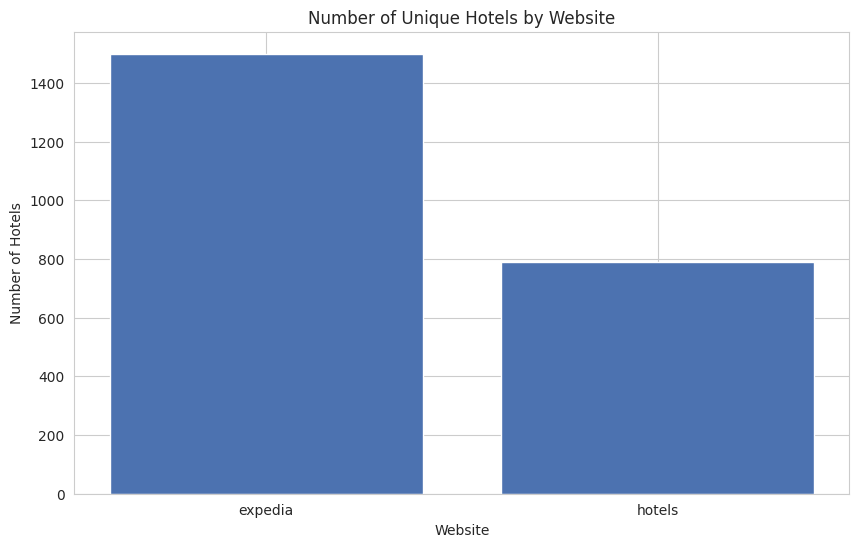

Number of unique hotels:
expedia: 1500
hotels: 791


In [223]:
hotel_counts = {website: df['hotel_name'].nunique() for website, df in clean_df.items()}

plt.figure(figsize=(10, 6))
plt.bar(hotel_counts.keys(), hotel_counts.values())
plt.title('Number of Unique Hotels by Website')
plt.xlabel('Website')
plt.ylabel('Number of Hotels')
plt.show()

print("Number of unique hotels:")
for website, count in hotel_counts.items():
    print(f"{website}: {count}")

Geographic coverage:


In [224]:
# Assuming 'city' and 'country' columns exist
location_counts = {website: {
    'cities': df['city'].nunique(),
} for website, df in clean_df.items()}

print("Geographic coverage:")
for website, counts in location_counts.items():
    print(f"{website}: {counts['cities']} cities")

Geographic coverage:
expedia: 14 cities
hotels: 25 cities


### Impact of Different Parameters

To analyze how segmenting the data by different parameters affects our comparisons, we'll focus on location and star ratings:

Price comparison by location (city):

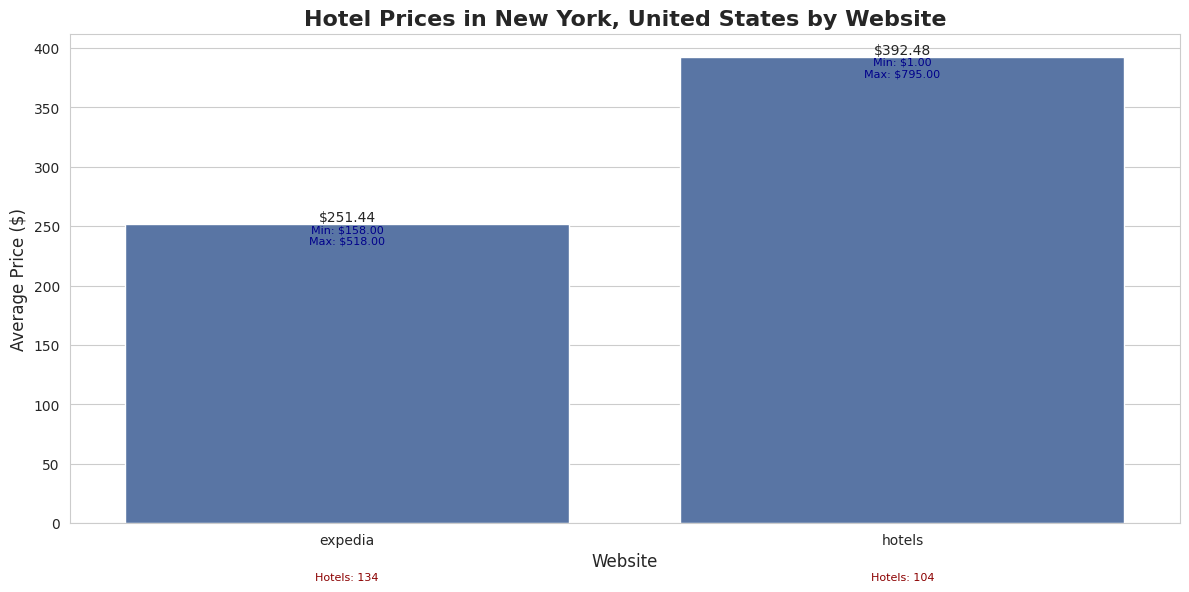

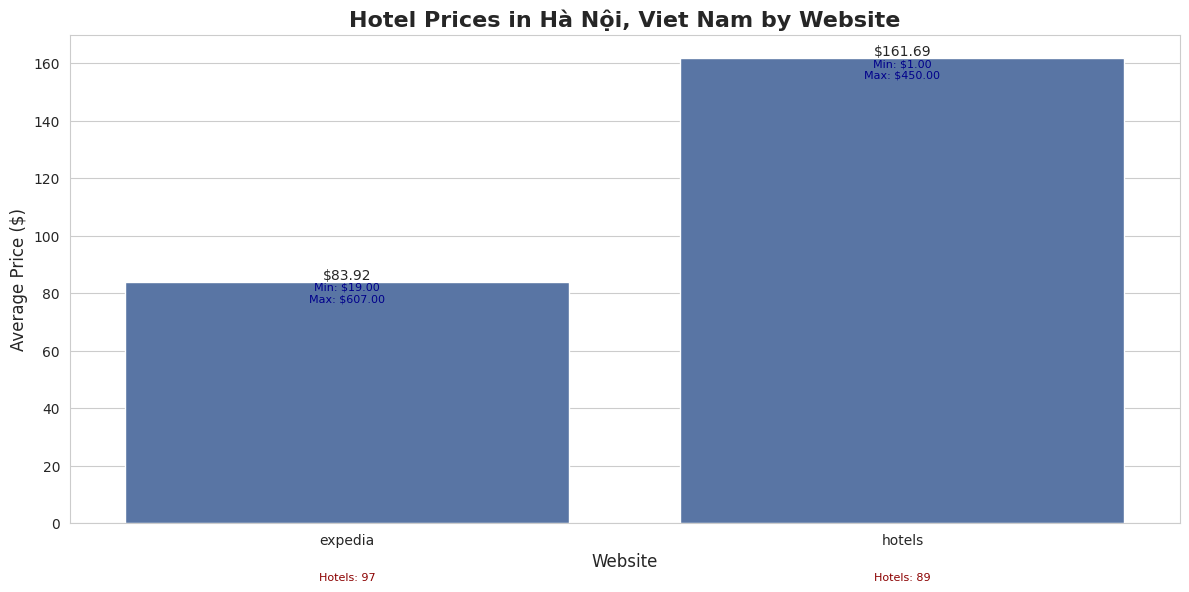

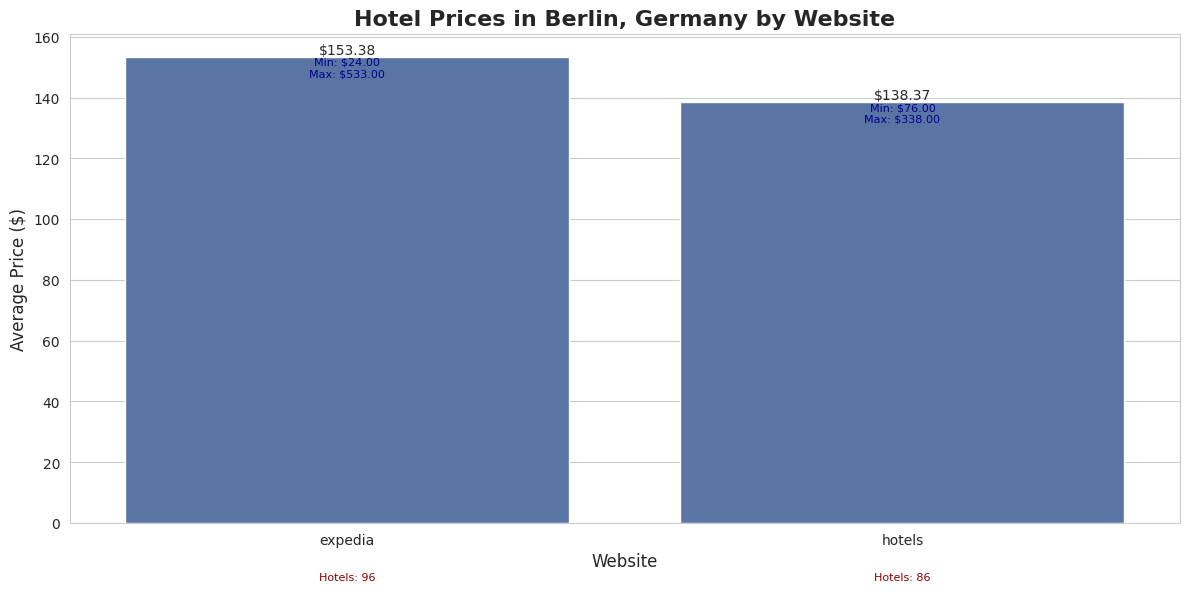

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


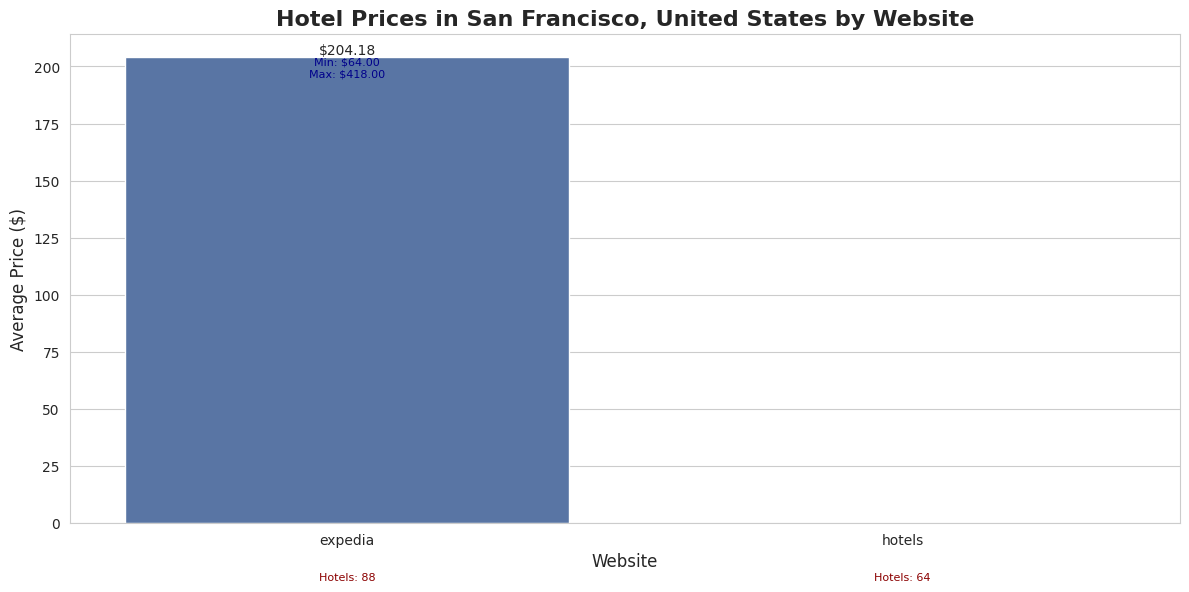

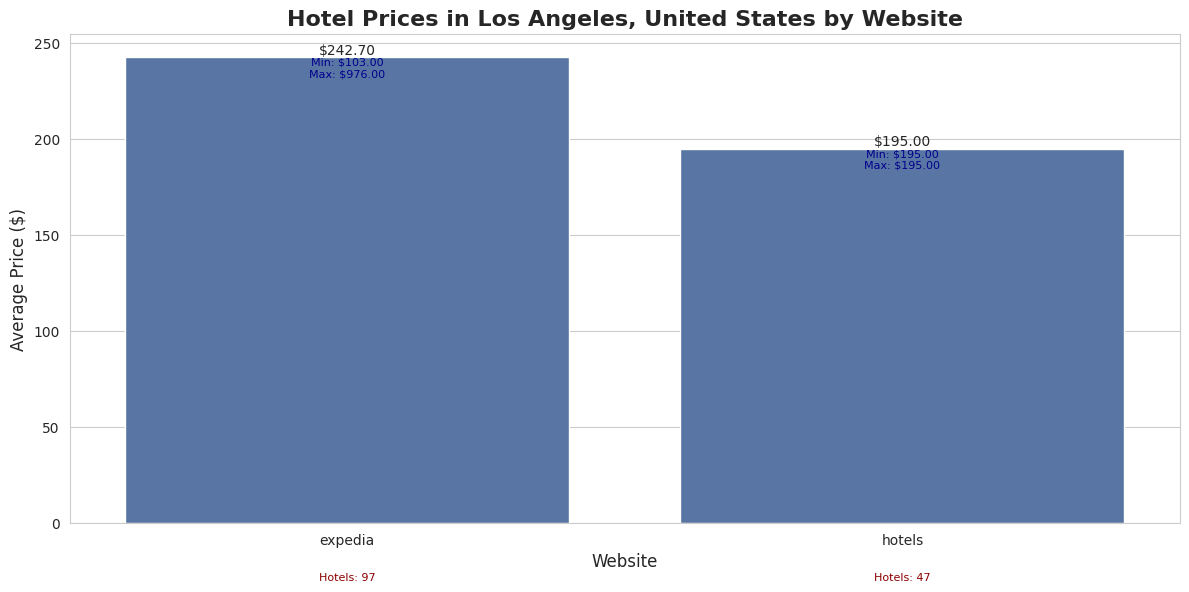

In [225]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def get_common_top_cities(clean_df, n=5):
    # Get cities that appear in both datasets
    expedia_cities = set(clean_df['expedia']['city'])
    hotels_cities = set(clean_df['hotels']['city'])
    common_cities = expedia_cities.intersection(hotels_cities)

    # Count hotels for common cities
    city_counts = {}
    for city in common_cities:
        expedia_count = clean_df['expedia'][clean_df['expedia']['city'] == city].shape[0]
        hotels_count = clean_df['hotels'][clean_df['hotels']['city'] == city].shape[0]
        city_counts[city] = expedia_count + hotels_count
    
    # Sort cities by total hotel count and get top n
    top_cities = sorted(city_counts.items(), key=lambda x: x[1], reverse=True)[:n]
    return [city for city, _ in top_cities]

def compare_prices_by_city(city, clean_df):
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    sns.set_palette("deep")

    data = []
    for website, df in clean_df.items():
        city_df = df[df['city'] == city]
        if not city_df.empty:
            data.append({
                'Website': website,
                'Average Price': city_df['price'].mean(),
                'Min Price': city_df['price'].min(),
                'Max Price': city_df['price'].max(),
                'Hotel Count': len(city_df)
            })
    
    if not data:
        print(f"No data available for {city}")
        return

    df = pd.DataFrame(data)
    
    ax = sns.barplot(x='Website', y='Average Price', data=df)
    
    # Add value labels on top of each bar
    for i, v in enumerate(df['Average Price']):
        ax.text(i, v, f'${v:.2f}', ha='center', va='bottom')

    # Add min and max prices as text
    for i, (_, row) in enumerate(df.iterrows()):
        ax.text(i, row['Average Price'], f"Min: ${row['Min Price']:.2f}\nMax: ${row['Max Price']:.2f}",
                ha='center', va='top', fontsize=8, color='darkblue')

    plt.title(f'Hotel Prices in {city} by Website', fontsize=16, fontweight='bold')
    plt.xlabel('Website', fontsize=12)
    plt.ylabel('Average Price ($)', fontsize=12)
    
    # Add hotel count as text below x-axis
    for i, (_, row) in enumerate(df.iterrows()):
        ax.text(i, -0.1, f"Hotels: {row['Hotel Count']}", ha='center', va='top', 
                transform=ax.get_xaxis_transform(), fontsize=8, color='darkred')

    plt.tight_layout()
    plt.show()

# Get top 5 common cities by hotel count
top_cities = get_common_top_cities(clean_df, n=5)

# Plot for top 5 common cities
for city in top_cities:
    compare_prices_by_city(city, clean_df)

In [ ]:
import folium
from folium.plugins import HeatMap
import pandas as pd

def create_price_heatmap(clean_df):
    # Combine data from both websites
    combined_df = pd.concat([
        clean_df['expedia'][['city', 'price']].assign(website='Expedia'),
        clean_df['hotels'][['city', 'price']].assign(website='Hotels.com')
    ])

    # Group by city and calculate average price
    city_prices = combined_df.groupby('city')['price'].mean().reset_index()

    # Create a base map
    m = folium.Map(location=[0, 0], zoom_start=2)
    geolocator = Nominatim(user_agent="my_app", timeout=10)
    # Prepare data for heatmap
    heat_data = []
    for _, row in city_prices.iterrows():
        try:
            
            # Geocode the city (you might want to use a cached version of this)
            location = geolocator.geocode(row['city'])
            if location:
                heat_data.append([location.latitude, location.longitude, row['price']])
        except Exception as e:
            print(f"Error geocoding {row['city']}: {str(e)}")

    # Add heatmap layer
    HeatMap(heat_data).add_to(m)

    # Add markers for each city with price information
    for _, row in city_prices.iterrows():
        try:
            location = geolocator.geocode(row['city'])
            if location:
                folium.Marker(
                    location=[location.latitude, location.longitude],
                    popup=f"{row['city']}: ${row['price']:.2f}",
                    tooltip=row['city']
                ).add_to(m)
        except Exception as e:
            print(f"Error adding marker for {row['city']}: {str(e)}")

    # Save the map
    m.save("hotel_price_heatmap.html")
    print("Heatmap saved as hotel_price_heatmap.html")

# Usage
create_price_heatmap(clean_df)

Price comparison by star rating:

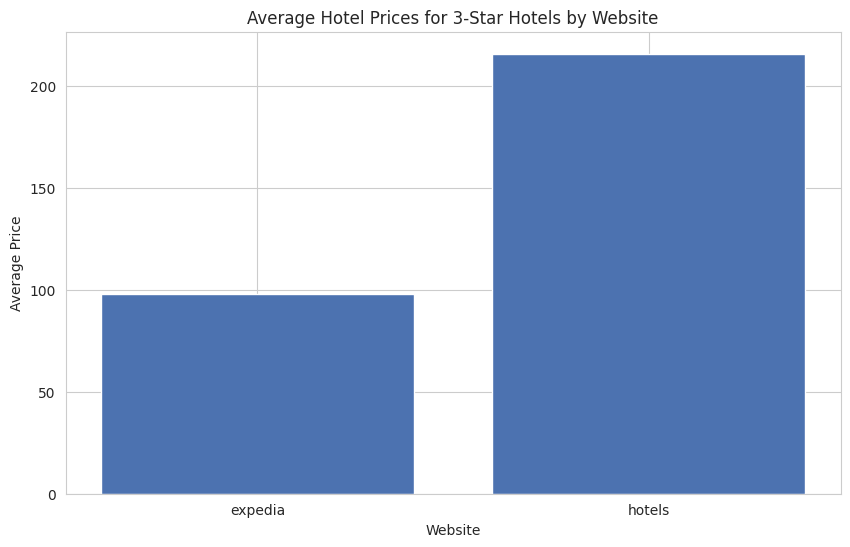

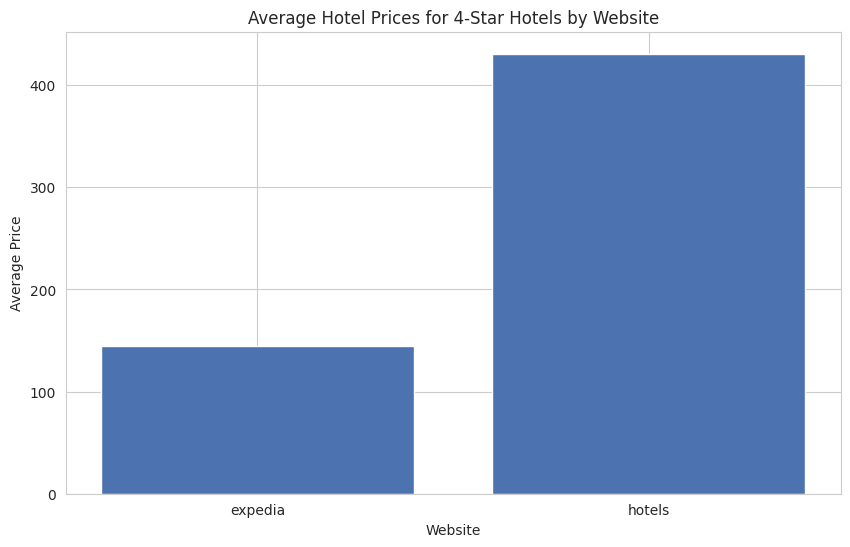

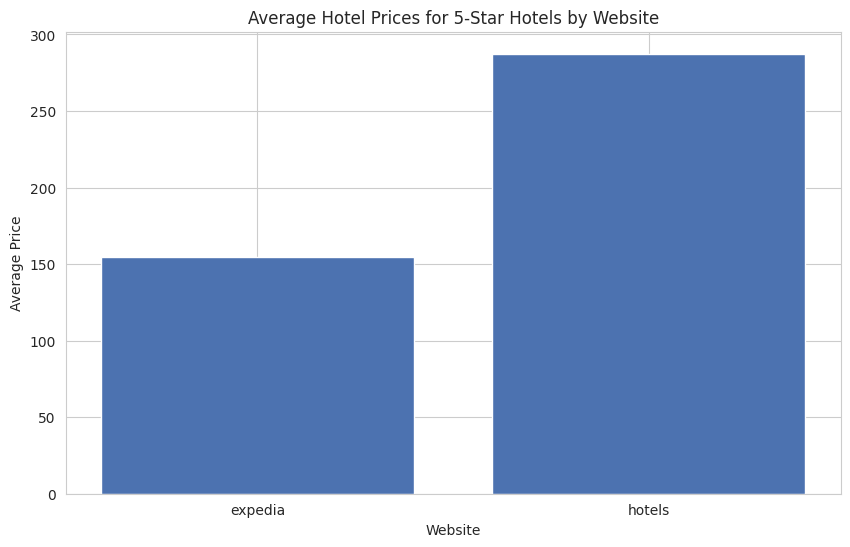

In [227]:
def compare_prices_by_stars(star_rating):
    star_prices = {}
    for website, df in clean_df.items():
        star_df = df[df['star_rating'] == star_rating]
        if not star_df.empty:
            star_prices[website] = star_df['price'].mean()
    
    plt.figure(figsize=(10, 6))
    plt.bar(star_prices.keys(), star_prices.values())
    plt.title(f'Average Hotel Prices for {star_rating}-Star Hotels by Website')
    plt.xlabel('Website')
    plt.ylabel('Average Price')
    plt.show()

# Example usage
for i in range(3,6):
    compare_prices_by_stars(i)

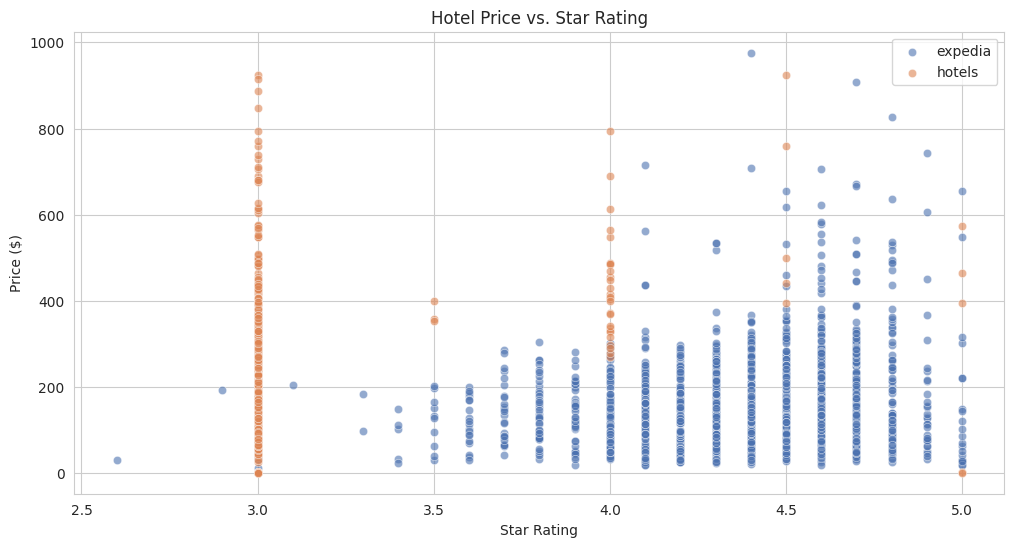

expedia price-rating correlation: 0.18
hotels price-rating correlation: 0.30


In [228]:
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_price_vs_rating(clean_df):
    plt.figure(figsize=(12, 6))
    for website, df in clean_df.items():
        sns.scatterplot(x='star_rating', y='price', data=df, label=website, alpha=0.6)
    
    plt.title('Hotel Price vs. Star Rating')
    plt.xlabel('Star Rating')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.show()

    # Calculate and print correlation coefficients
    for website, df in clean_df.items():
        correlation = df['price'].corr(df['star_rating'])
        print(f"{website} price-rating correlation: {correlation:.2f}")

# Usage
analyze_price_vs_rating(clean_df)

- From the above analysis, we can see that expedia has a lower average price compared to hotels.com. 

- Hotels.com also has a higher median price and a smaller interquartile range, indicating that the majority of the hotels 
on Hotels.com are more expensive than those on Expedia.com. 

- The price distributions for both websites are left-skewed, with more hotels concentrated in the lower price range. 

- Expedia has a higher percentage of hotels below $100 compared to hotels.com, which may indicate a wider range of budget-friendly options on Expedia.

- The number of unique hotels on Expedia is higher than on Hotels.com, indicating a larger inventory of properties on Expedia.

- The geographic coverage is similar for both websites, with the top 5 common cities having a good representation on both platforms.

- Segmenting the data by star rating shows that the average price increases with the star rating, as expected. Hotels.com tends to have more 
expensive options overall, likely due to the inclusion of luxury and boutique hotels that are not as prevalent on Expedia.

- When comparing prices by city, we observe that the average price can vary significantly across different cities. 